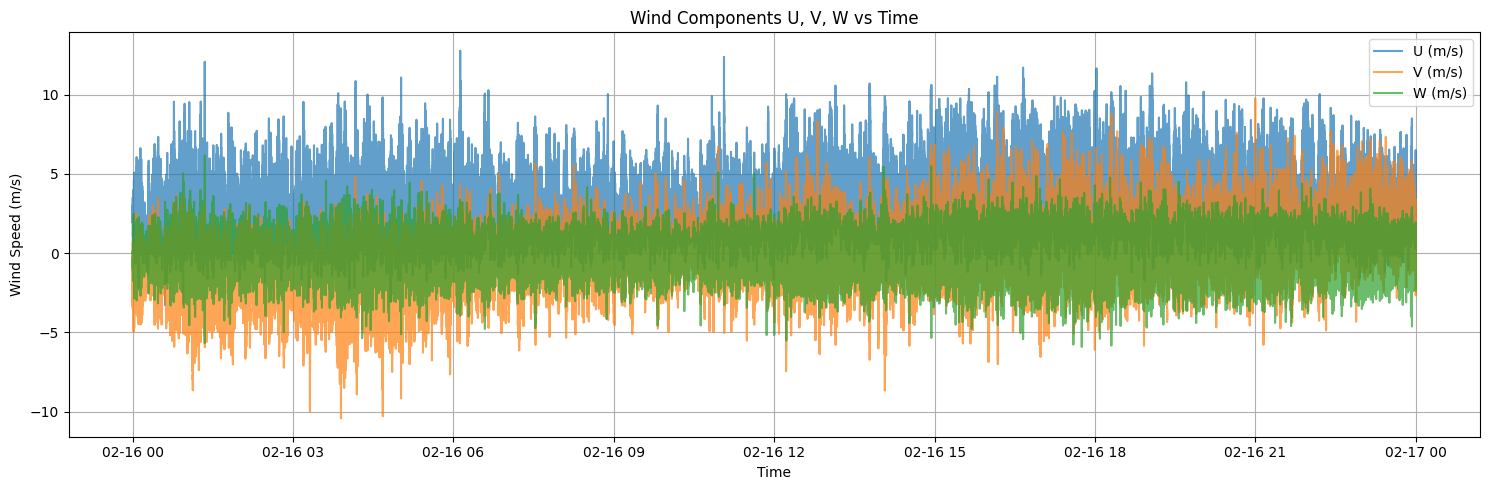

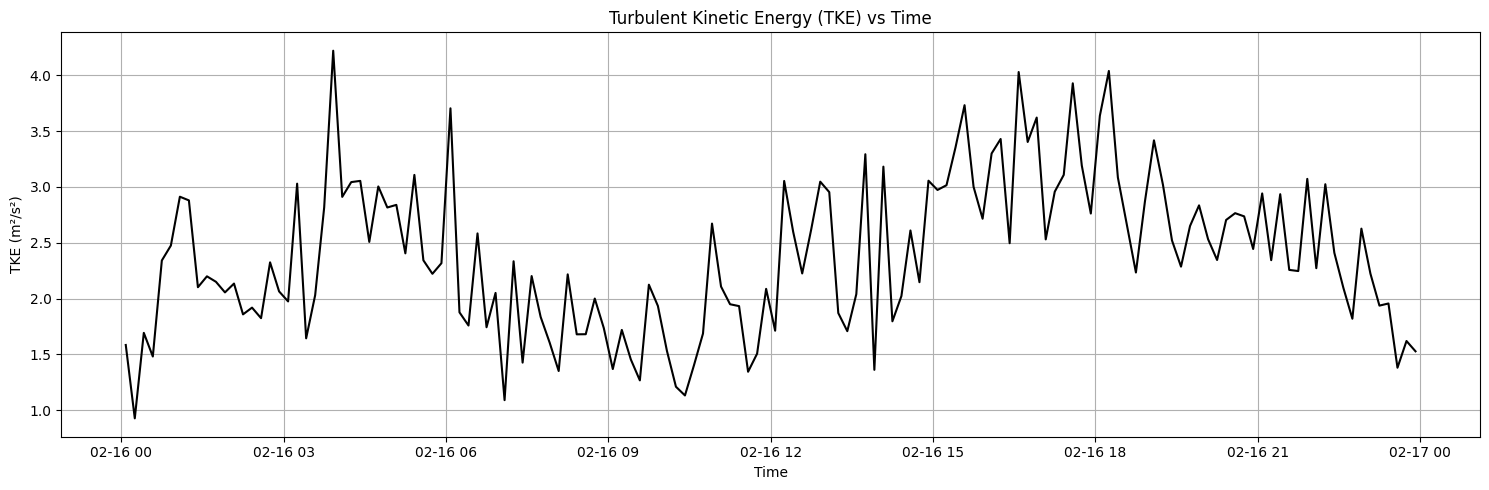

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import detrend

# Load the NetCDF file
file_path = "/Users/pmuradyan/Downloads/crocus-uic-smartflux-raw-20250216T235959.nc"
ds = xr.open_dataset(file_path)

# Time variable is in datetime format "seconds since 1970-01-01")
time = pd.to_datetime(ds["time"].values)

# Extract U, V and W wind components
u = ds["U_m_s"].values
v = ds["V_m_s"].values
w = ds["W_m_s"].values

# Pad fill values with NaN
u[u == -9999] = np.nan
v[v == -9999] = np.nan
w[w == -9999] = np.nan

# Create DataFrame
df = pd.DataFrame({
    "time": time,
    "u": u,
    "v": v,
    "w": w
}).dropna()

# Calculate TKE: TKE generally calculated in 10-minute windows. Urban Canyon ANL Sonic data is in 10 Hz.   
# Window size for 32 Hz data would be: 32 Hz * 600 s 
window_size = 10 * 600 # 10 minutes

tke_list = []
time_midpoints = []

for i in range(0, len(df), window_size):
    window = df.iloc[i:i+window_size]
    if len(window) < window_size:
        continue
    
    u_prime = window["u"] - window["u"].mean()
    v_prime = window["v"] - window["v"].mean()
    w_prime = window["w"] - window["w"].mean()

    tke = 0.5 * (np.var(u_prime, ddof=1) +
             np.var(v_prime, ddof=1) +
             np.var(w_prime, ddof=1))
    
    tke_list.append(tke)
    time_midpoints.append(window["time"].iloc[window_size // 2])

# Plot U, V, W vs time
plt.figure(figsize=(15, 5))
plt.plot(df["time"], df["u"], label="U (m/s)", alpha=0.7)
plt.plot(df["time"], df["v"], label="V (m/s)", alpha=0.7)
plt.plot(df["time"], df["w"], label="W (m/s)", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Wind Speed (m/s)")
plt.title("Wind Components U, V, W vs Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot TKE vs time
plt.figure(figsize=(15, 5))
plt.plot(time_midpoints, tke_list, label="TKE (m²/s²)", color="black")
plt.xlabel("Time")
plt.ylabel("TKE (m²/s²)")
plt.title("Turbulent Kinetic Energy (TKE) vs Time")
plt.grid(True)
plt.tight_layout()
plt.show()
